In [1]:
from IPython.display import Image
import itertools

import numpy as np
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

## A Birth-Death Process for Feature Allocation

This notebook outlines the paper [A Birth-Death Process for Feature Allocation](http://proceedings.mlr.press/v70/palla17a/palla17a.pdf), by K. Palla, D. Knowles, and Z. Ghahramani, which extends the [Indian buffet process](https://en.wikipedia.org/wiki/Indian_buffet_process) to sequential data.

### 1.  The Indian Buffet Process

The [Indian buffet process](https://en.wikipedia.org/wiki/Indian_buffet_process) (IBP) describes a latent feature process in which an observation $\mathbf{x}_{i}$ is associated with an unbounded binary vector $\mathbf{z}_{i}$.  Each element in $\mathbf{z}_{i}$ represents a binary feature such that $z_{i,k}=1$ if $\mathbf{x}_{i}$ exhibits the $k$th latent feature.  The IBP can be constructed from a Beta-Bernoulli process via two stages of sampling.  The first stage samples $B = \sum_{k=1}^{\infty} \omega_{k} \delta_{\theta_{k}}$ and the second samples features according to the weights, i.e. $z_{k} \sim \text{Bernoulli}(\omega_{k})$.


### 2.  A Birth-Death Process for Feature Allocation

Palla et al. define their dynamic extension to the IBP by considering a continuous-time Markov jump process over all possible $N \times K$ feature allocations.  Jumps correspond to features being 'born' and 'dying.'  The process can be represented by the following finite model, termed the *Beta Event Process* (BEP): $$ \mid \mathcal{F} \mid \sim \text{Poisson}(KT), $$ $$ \omega_{k} \sim \text{Beta}(R/K, 1), \ \  t_{b}^{k} \sim \text{Uniform}(0, T), \ \ t_{\omega}^{k} \sim \text{Exponential}(D)$$ for $k=1,\ldots, \mid \mathcal{F} \mid$ features.  $\omega_{k}$ is, again, the probability of sampling feature $k$, $t_{b}^{k}$ is the birth time of feature $k$, and $t_{d}^{k} = t_{b}^{k} + t_{\omega}^{k}$ is the $k$th feature's death time.  Once a sample from the BEP is drawn, the dynamic feature matrix can be constructed as follows: $$ s_{i,k} \sim \text{Bernoulli}(\omega_{k}), \ \ \ z_{i,k}(t) = s_{i,k} \mathbb{I}[t_{b}^{k} < t < t_{d}^{k}].$$  Notice that the feature matrix $z_{i,k}(t)$ can be constructed deterministically from the global matrix $\mathbf{s}$ and the birth/death times for feature $k$.    

### 3.  Neural Variational Inference for the BEP

It is interesting to consider if neural variational inference could be applied to the BEP.  Contruction of the $\mathbf{s}$ vector is easy, essentially following [Singh et al.'s (2017)](http://approximateinference.org/2017/accepted/SinghEtAl2017.pdf) approach.  Inference for the birth/death times is the challenging part.  One approach is to model only the feature duration $t_{\omega}^{k}$, which can be done using an initiation signal and an exponential clock.  Concretely, we can parametrize a sample from the feature matrix as $$ \hat{z}_{i,k}(t) = s_{i,k} \  \pi_{i,k} \ \mathbb{I}[\sum_{j} \hat{t} < D] $$

In [23]:
# Gaussian
def log_normal_pdf(x, mu, sigma):
    d = mu - x
    d2 = tf.mul(-1., tf.mul(d,d))
    s2 = tf.mul(2., tf.mul(sigma,sigma))
    return tf.reduce_sum(tf.div(d2,s2) - tf.log(tf.mul(sigma, 2.506628)))

# Gaussian Mixture
def log_gaussMix_pdf(z, pi, mu, sigma, K):
    s = tf.mul(pi[0], tf.exp(log_normal_pdf(z, mu[0], sigma[0])))
    for k in xrange(K-1):
        s += tf.mul(pi[k+1], tf.exp(log_normal_pdf(z, mu[k+1], sigma[k+1])))
    return tf.log(s)

And plot it...

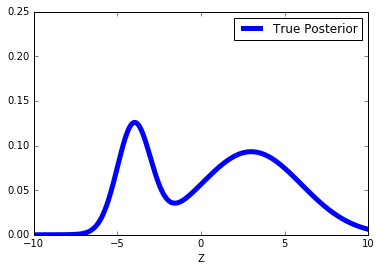

In [24]:
#'true' posterior params
mu_post = [-4., 3.]
sigma_post = [1., 3.]
pi_post = [.3, .7]

Z = tf.placeholder(tf.float32, shape=(), name="init")
log_prob_z = log_gaussMix_pdf(Z, pi_post, mu_post, sigma_post, 2)

# get posterior probabilities
z_grid = np.linspace(-10., 10., 1000).astype('float32')
with tf.Session() as session:
    probs_true = np.exp([session.run(log_prob_z, {Z: z}) for z in z_grid])

plt.figure()

plt.plot(z_grid, probs_true, 'b-', linewidth=5, label="True Posterior")

plt.xlabel("Z")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()

Now let's define our adaptive inference RNN, starting with the recurrent component...

In [86]:
# define dimensionality of model components
input_d = 1
rnn_hidden_d = 5
z_space_d = 1

max_n_loops = 10

# init data variable
X = tf.placeholder("float", [None, input_d])

# init RNN params
params = {'h':{'W':tf.Variable(tf.random_normal([input_d, rnn_hidden_d], stddev=.001)),
               'U':tf.Variable(tf.random_normal([rnn_hidden_d, rnn_hidden_d], stddev=.001)),
               'b':tf.Variable(tf.zeros([rnn_hidden_d,]))
              },
          'mu':{'W':tf.Variable(tf.random_normal([rnn_hidden_d, z_space_d], stddev=.001)),
               'b':tf.Variable(tf.zeros([z_space_d,]))
              },
          'sigma':{'W':tf.Variable(tf.random_normal([rnn_hidden_d, z_space_d], stddev=.001)),
               'b':tf.Variable(tf.zeros([z_space_d,]))
              },
          'pi':{'W':tf.Variable(tf.random_normal([rnn_hidden_d, 1], stddev=.001) - .3),
               'b':tf.Variable(tf.zeros([1,]))
              }
        }


### DEFINE RNN LOOP ###
def prop_RNN(hidden_state):

    # Defines an Elman network
    # TODO: define LSTM cell
    hidden_state = \
    tf.nn.relu(tf.matmul(X, params['h']['W']) + tf.matmul(hidden_state, params['h']['U']) + params['h']['b'])
    
    return hidden_state

hidden_states = [tf.zeros([tf.shape(X)[0], rnn_hidden_d])]

for loop_idx in range(max_n_loops):
    hidden_states.append( prop_RNN(hidden_states[-1]) )
    
# remove inital state
hidden_states = hidden_states[1:]

Next we take the hidden states and determine how many components to compute...

In [87]:
pis = []
mus = []
sigmas = []
remaining_stick = 1.

stick_eps = .01
for idx in range(max_n_loops-1):
    
    # compute component params
    mus.append(tf.matmul(hidden_states[idx], params['mu']['W']) + params['mu']['b'])
    sigmas.append(tf.nn.softplus(tf.matmul(hidden_states[idx], params['sigma']['W']) + params['sigma']['b']))
    
    # compute component weights
    gamma = tf.nn.sigmoid(tf.matmul(hidden_states[idx], params['pi']['W']) + params['pi']['b'])
    
    length_check = tf.reduce_max((1.-gamma)*remaining_stick)
    gamma = tf.cond( length_check < stick_eps, lambda: 0.*gamma + 1., lambda: gamma ) 
    
    pis.append(gamma * remaining_stick)
    remaining_stick = (1.-gamma)*remaining_stick
    
# perform last iteration with pi set to remaining stick
mus.append(tf.matmul(hidden_states[-1], params['mu']['W']) + params['mu']['b'])
sigmas.append(tf.nn.softplus(tf.matmul(hidden_states[-1], params['sigma']['W']) + params['sigma']['b']))
pis.append(remaining_stick)

Now let's define our optimization function...

In [88]:
regularization_weight = tf.placeholder(tf.float32, shape=(), name="regWeight")

# data term: \sum_k \pi_k E[log p(x,z)]
expected_ll = 0.
pi_sum_tracker = 0.
for k in range(max_n_loops):
    z_sample = mus[k] + sigmas[k] * tf.random_normal(shape=[tf.shape(X)[0], z_space_d])
    expected_ll += pis[k] * log_gaussMix_pdf(z_sample, pi_post, mu_post, sigma_post, 2)
    
# entropy lower bound term : -\sum_k pi_k log \sum_j pi_j N(mu_k; mu_j, sigma_k**2 + sigma_j**2)
ent_lb_term = 0.
for k in range(max_n_loops):
    temp_val = 0.
    for j in range(max_n_loops):
        temp_val += pis[j] * tf.exp(log_normal_pdf(mus[k], mus[j], tf.sqrt(sigmas[k]**2 + sigmas[j]**2)))
    ent_lb_term += -pis[k] * tf.log(temp_val + .0001)
    
# entropy of mixture weights
ent_mix_weights = 0.
for k in range(max_n_loops):
    ent_mix_weights += -pis[k] * tf.log(pis[k] + .001)
    
# final objective
objective_fn = tf.reduce_mean(expected_ll + ent_lb_term - regularization_weight * ent_mix_weights)

# collect parameters
final_pis = tf.concat(2, [tf.expand_dims(t, 2) for t in pis])
final_mus = tf.concat(2, [tf.expand_dims(t, 2) for t in mus])
final_sigmas = tf.concat(2, [tf.expand_dims(t, 2) for t in sigmas])

Lastly, let's train our dynamic RNN approximation...

In [90]:
# Set training params
n_epochs = 1500
learning_rate = .003

# get the training operator
train_model = tf.train.AdamOptimizer(learning_rate).minimize(-objective_fn, \
                    var_list=[params['h']['W'], params['h']['U'], params['h']['b'], 
                     params['mu']['W'], params['mu']['b'],
                      params['sigma']['W'], params['sigma']['b'],
                      params['pi']['W'], params['pi']['b']])

reg_weights = np.linspace(0., .99, int(n_epochs * .85)).astype('float32').tolist()

with tf.Session() as session:
    tf.initialize_all_variables().run()
    
    obj_tracker = 0.
    for epoch_idx in xrange(n_epochs):
        
        # perform update
        if epoch_idx < len(reg_weights): w = reg_weights[epoch_idx]
        else: w = reg_weights[-1]
            
        _, obj = session.run([train_model, objective_fn], feed_dict={X: np.random.normal(scale=1.5, size=(5,1)), regularization_weight:w})
        obj_tracker += obj
    
        if (epoch_idx+1) % 10 == 0:
            print "Epoch %d.  VI Objective: %.3f" %(epoch_idx+1, obj_tracker/10)
            obj_tracker = 0.

    m, s, p = session.run([final_mus, final_sigmas, final_pis], feed_dict={X: np.ones((5,1))})

Epoch 10.  VI Objective: -8.537
Epoch 20.  VI Objective: -8.448
Epoch 30.  VI Objective: -8.037
Epoch 40.  VI Objective: -7.563
Epoch 50.  VI Objective: -7.122
Epoch 60.  VI Objective: -5.757
Epoch 70.  VI Objective: -5.647
Epoch 80.  VI Objective: -4.885
Epoch 90.  VI Objective: -4.707
Epoch 100.  VI Objective: -4.181
Epoch 110.  VI Objective: -3.786
Epoch 120.  VI Objective: -3.577
Epoch 130.  VI Objective: -3.371
Epoch 140.  VI Objective: -3.603
Epoch 150.  VI Objective: -3.220
Epoch 160.  VI Objective: -3.152
Epoch 170.  VI Objective: -3.186
Epoch 180.  VI Objective: -3.150
Epoch 190.  VI Objective: -2.910
Epoch 200.  VI Objective: -3.096
Epoch 210.  VI Objective: -2.973
Epoch 220.  VI Objective: -3.064
Epoch 230.  VI Objective: -2.960
Epoch 240.  VI Objective: -3.500
Epoch 250.  VI Objective: -3.151
Epoch 260.  VI Objective: -2.912
Epoch 270.  VI Objective: -3.154
Epoch 280.  VI Objective: -2.821
Epoch 290.  VI Objective: -2.981
Epoch 300.  VI Objective: -2.903
Epoch 310.  VI Obje

The first axis just holds a fake mini-batch. Just throw it away...

In [91]:
m, s, p = m[0, :, :], s[0, :, :], p[0, :, :]

print "Mu: "+str(m)
print "Sigma: "+str(s)
print "Pis: "+str(p)

print
print np.sum(p)
print m.shape

Mu: [[ 1.45938182  2.00045443  2.26869678  2.40168095  2.46760941  2.50029421
   2.51649809  2.52453136  2.52851391  2.53048801]]
Sigma: [[ 1.29975712  1.52779758  1.64672446  1.70699334  1.73717713  1.75221407
   1.75968647  1.76339531  1.76523507  1.76614738]]
Pis: [[  2.03227485e-03   1.61816744e-04   4.61592426e-05   2.47847638e-05
    1.82091826e-05   1.56281312e-05   1.44875357e-05   1.39532076e-05
    1.36955960e-05   9.97659147e-01]]

1.0
(1, 10)


Let's visualize the approximation...

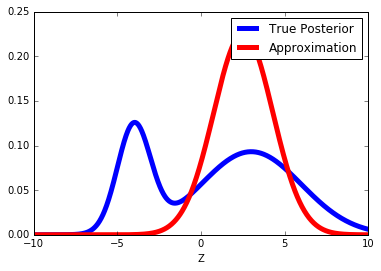

In [92]:
from scipy.stats import norm

probs_approx = [np.sum([p[0,k] * norm.pdf(z, loc=m[0, k], scale=s[0,k]) for k in range(max_n_loops)]) for z in z_grid]

plt.figure()

plt.plot(z_grid, probs_true, 'b-', linewidth=5, label="True Posterior")
plt.plot(z_grid, probs_approx, 'r-', linewidth=5, label="Approximation")

plt.xlabel("Z")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()